# Imports and Loading

In [2]:
# Loading the required libraries
%pip install nbimporter
import nbimporter
import feature_extraction
from feature_extraction import EmpathFeatureExtractor
from feature_extraction import NGramFeatureExtractor
from feature_extraction import EmpathFeatureAnalyzer
from feature_extraction import LDAFeatureExtractor
import os
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%store -r selected_categories

Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name 'EmpathFeatureExtractor' from 'feature_extraction' (unknown location)

In [30]:
# Load documents and labels
folders = {
    "depression": {"path": "data/preprocessed_posts/depression", "label": 1},
    "breastcancer": {"path": "data/preprocessed_posts/standard", "label": 0},
}
documents, labels = [], []
for category, data in folders.items():
    for file_name in os.listdir(data["path"]):
        file_path = os.path.join(data["path"], file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            documents.append(file.read())
            labels.append(data["label"])
print(f"Loaded {len(documents)} documents.")
print(f"Labels: {set(labels)}")

Loaded 1890 documents.
Labels: {0, 1}


# Frequency and Predictive Power of N-gram Features

In [31]:
# Extracting n-gram features
ngram_extractor = NGramFeatureExtractor(documents, labels)
ngram_extractor.extract_features()
depression_unigram_freqs, non_depression_unigram_freqs = ngram_extractor.compute_frequencies(feature_type="unigram")
depression_bigram_freqs, non_depression_bigram_freqs = ngram_extractor.compute_frequencies(feature_type="bigram")
top_100_depression_unigrams = ngram_extractor.get_top_n_features(depression_unigram_freqs, top_n=100)
print(top_100_depression_unigrams)
top_100_non_depression_unigrams = ngram_extractor.get_top_n_features(non_depression_unigram_freqs, top_n=100)
print(top_100_non_depression_unigrams)
top_100_depression_bigrams = ngram_extractor.get_top_n_features(depression_bigram_freqs, top_n=100)
print(top_100_depression_bigrams)
top_100_non_depression_bigrams = ngram_extractor.get_top_n_features(non_depression_bigram_freqs, top_n=100)
print(top_100_non_depression_bigrams)
ngram_extractor.visualize_wordcloud(depression_unigram_freqs, "Depression Unigram Word Cloud")
ngram_extractor.visualize_wordcloud(non_depression_unigram_freqs, "Non-Depression Unigram Word Cloud")
ngram_extractor.visualize_wordcloud(depression_bigram_freqs, "Depression Bigram Word Cloud")
ngram_extractor.visualize_wordcloud(non_depression_bigram_freqs, "Non-Depression Bigram Word Cloud")

Extracting unigrams...
Number of unigram features: 11693
Extracting bigrams...
Number of bigram features: 68385
Extracting combined unigrams and bigrams...
Number of combined unigram and bigram features: 80078
[('like', 51.45728544053958), ('feel', 51.279073837557924), ('want', 33.686688567162534), ('know', 29.905790860173205), ('life', 27.896264320748017), ('year', 25.545830021493213), ('think', 25.514367745390576), ('time', 24.965540445643637), ('realli', 23.461388091048732), ('tri', 22.21314591705759), ('thing', 21.649044760429536), ('make', 20.656525425721096), ('depress', 20.43112536307388), ('friend', 17.95742131998935), ('peopl', 17.892595905570552), ('day', 16.535746986529517), ('start', 15.37770855466726), ('live', 15.063534946958349), ('sinc', 14.7434849141476), ('anyth', 14.402246198868879), ('wish', 14.378735747410444), ('everyth', 14.372489454885283), ('alway', 14.151690934971757), ('got', 14.013069723844573), ('famili', 14.011655996434042), ('talk', 13.977680251610074), (

AttributeError: 'NGramFeatureExtractor' object has no attribute 'visualize_wordcloud'

# Predictive Power of Empath Features

In [3]:
# Analyzing the Empath model
empath_analyzer = EmpathFeatureAnalyzer(documents, labels, selected_categories)

# Run the pipeline
empath_analyzer.extract_empath_features()
empath_analyzer.analyze_correlation()
empath_analyzer.group_correlations_by_subcategory()

# Generate and visualize the summary table
summary_table = empath_analyzer.generate_summary_table()
empath_analyzer.visualize_summary_table()


Extracted Empath features with shape: (293, 237)
Removed constant columns: ['articles', 'auxiliary_verbs', 'adverbs', 'conjunctions', 'personal_pronouns', 'impersonal_pronouns', 'negations', 'prepositions', 'verbs', 'nouns', 'adjectives', 'comparatives', 'superlatives', 'modifiers', 'function_words', 'filler_words', 'verb_tense', 'slang', 'jargon', 'formal_language', 'casual_language', 'exclamations', 'contractions', 'word_complexity', 'sentiment_words', 'anxiety', 'hope', 'excitement', 'relief', 'gratitude', 'guilt', 'boredom', 'embarrassment', 'longing', 'nostalgia', 'frustration', 'melancholy', 'illness', 'fitness', 'nutrition', 'ingestion', 'physical_state', 'medicine', 'aging', 'disease', 'hospital', 'recovery', 'dieting', 'mental_health', 'drug_use', 'headache', 'fatigue', 'hormones', 'appetite', 'relationships', 'group_behavior', 'teamwork', 'community', 'peer_pressure', 'leadership', 'parenting', 'mentorship', 'marriage', 'divorce', 'gender_roles', 'social_identity', 'cultural_

# Predictive Power of LDA Features

Preprocessing documents...
Training LDA model...
Extracting topic distributions...
Saving features...
Saving file to: data/feature_extracted_data/lda_topic_distributions_with_labels.csv
File already exists at data/feature_extracted_data/lda_topic_distributions_with_labels.csv.
Visualizing t-SNE...


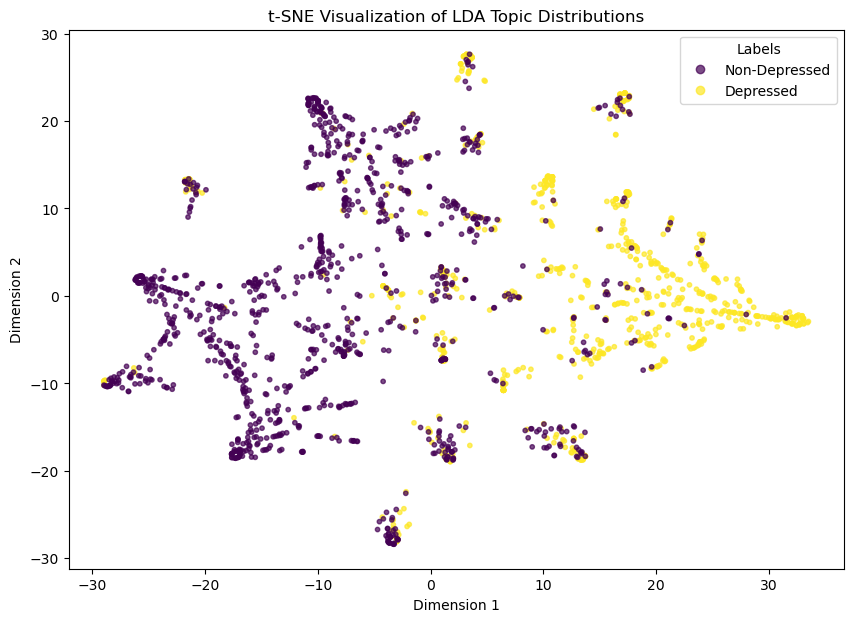

LDA pipeline complete.
Extracting topic matrix...
Topic matrix shape: (1878, 20)
Performing t-SNE...
t-SNE completed.
Visualizing t-SNE results...


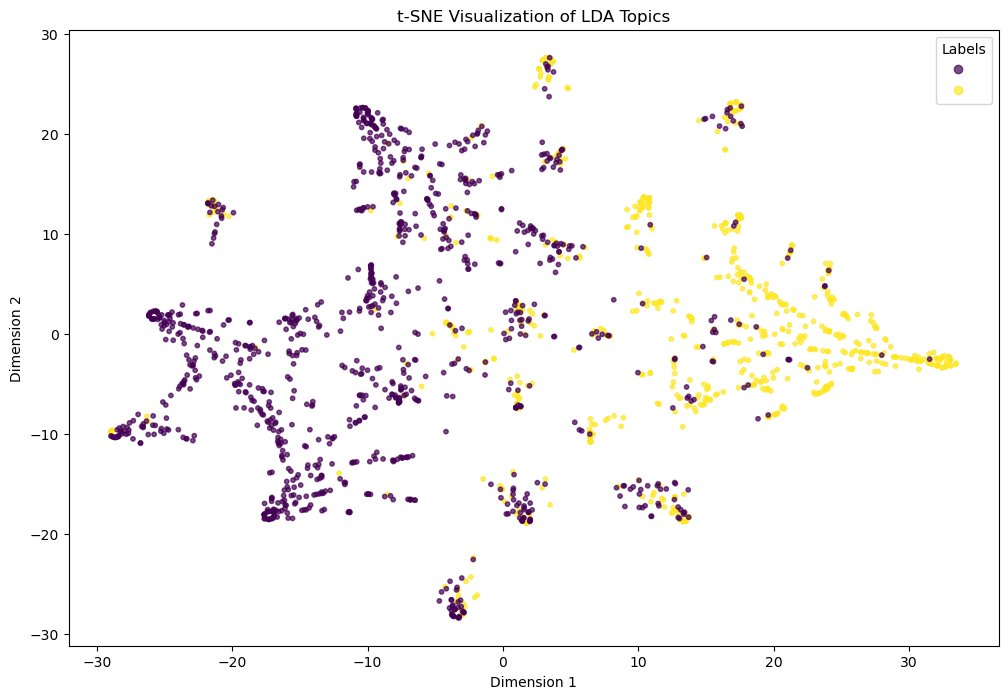

Analyzing topics...
Topic 0: like, look, year, get, feel, back, could, tri, hou, think
Topic 1: time, year, peopl, parent, like, good, show, make, need, could
Topic 2: like, eat, use, know, plan, food, would, want, also, get
Topic 3: feel, like, want, know, time, life, get, go, even, thing
Topic 4: get, day, week, go, feel, chemo, start, know, one, like
Topic 5: iron, take, night, sleep, scare, tri, mother, get, time, normal
Topic 6: like, wish, realli, anyth, hate, interest, thing, could, car, tri
Topic 7: ask, bank, told, go, like, call, see, back, phone, feel
Topic 8: like, black, sub, look, anyon, date, white, post, girl, thank
Topic 9: feel, like, depress, want, tri, know, year, month, time, even
Topic 10: breast, cancer, radiat, http, stage, patient, right, month, left, pain
Topic 11: like, famili, us, realli, even, go, mom, believ, said, home
Topic 12: want, im, like, dont, think, know, would, life, noth, depress
Topic 13: surgeri, get, cancer, would, radiat, breast, surgeon, ma

/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


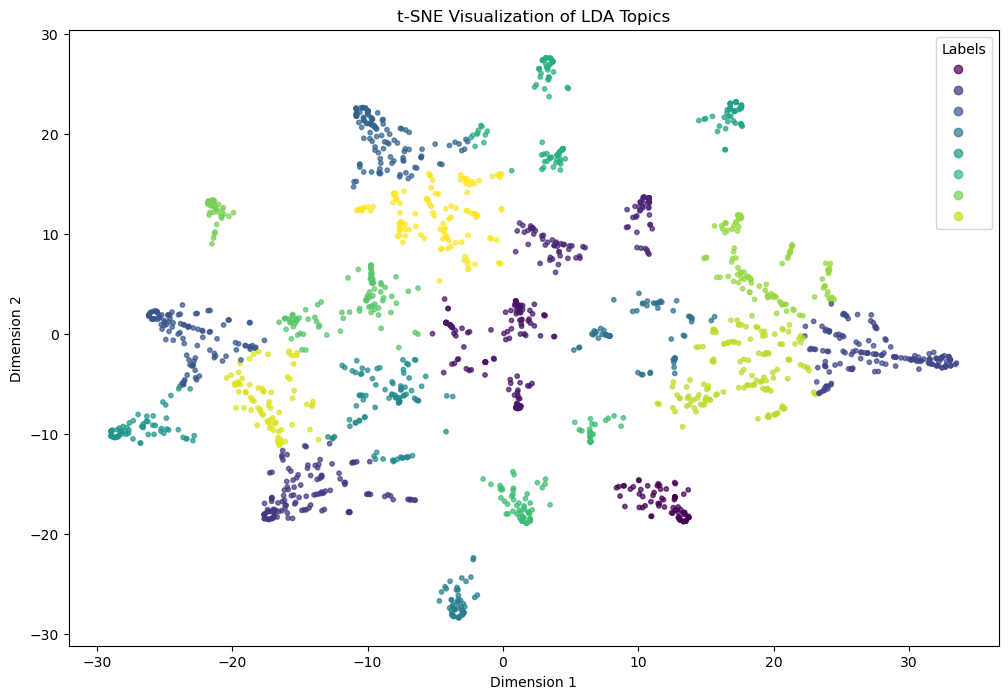

In [25]:
lda_extractor = LDAFeatureExtractor(documents, labels, num_topics=20, passes=15)

# Step 2: Run the LDA pipeline to extract topics and features
lda_extractor.run_pipeline()

# Step 3: Retrieve the extracted LDA features
topic_matrix = lda_extractor.topic_distribution_to_matrix()
lda_model = lda_extractor.lda_model
corpus = lda_extractor.corpus
dictionary = lda_extractor.dictionary


lda_analyzer = LDAFeatureAnalyzer(lda_extractor)
lda_analyzer.run_analysis(perplexity=50, n_iter=500, n_clusters=20, labels=labels)


